In [1]:
import os
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np

dataDir = r'C:\Users\tr17\Dropbox\fcmr_seg'
imDir   = dataDir+r'\images'
segsDir = dataDir+r'\segs'

os.chdir(dataDir)

C:\Users\tr17\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def cropSliceMaskCentroid(img_slice, mask_slice):
  
  """ cropSliceMaskCentroid
  
  input:
  - img_slice: 2D array
  - mask_slice: 2D binary mask corresponding to img_slice

  output:
  - img_slice_crop: cropped version of img_slice
  - mask_slice_crop: cropped version of mask_slice

  note:
  currently hard-coded to return 64x64 images

  """
  
  # Crop image using centrepoint of image if no mask
  if not np.any(mask_slice):
    nX = mask_slice.shape[0]; nY = mask_slice.shape[1]
    img_centre = ( int(round(nX/2)), int(round(nY/2)) )
    dimX_crop = [img_centre[0]-32, img_centre[0]+32]
    dimY_crop = [img_centre[1]-32, img_centre[1]+32]
    img_slice_crop = img_slice[dimX_crop[0]:dimX_crop[1],dimY_crop[0]:dimY_crop[1]]
    mask_slice_crop = mask_slice[dimX_crop[0]:dimX_crop[1],dimY_crop[0]:dimY_crop[1]]

    return img_slice_crop, mask_slice_crop 

  # Crop image using centre of mask
  idxMask = np.where(mask_slice)

  iMin = min(idxMask[0])
  iMax = max(idxMask[0])
  jMin = min(idxMask[1])
  jMax = max(idxMask[1])
  midPoint = ( iMin + int(round((iMax-iMin)/2)), jMin + int(round((jMax-jMin)/2)) )

  # print("i coords ...", iMin, ":", iMax)
  # print("j coords ...", jMin, ":", jMax)
  # print("midpoint ...", midPoint)

  iCmin = midPoint[0] - 32
  iCmax = midPoint[0] + 32
  jCmin = midPoint[1] - 32
  jCmax = midPoint[1] + 32
  downsampleCoords = [ range(iCmin,iCmax), range(jCmin,jCmax) ]

  # print("i downsample coords ...", iCmin, ":", iCmax)
  # print("j downsample coords ...", jCmin, ":", jCmax)

  img_slice_crop  = img_slice[iCmin:iCmax,jCmin:jCmax]
  mask_slice_crop = mask_slice[iCmin:iCmax,jCmin:jCmax]

  # plt.imshow(img_slice[iCmin:iCmax,jCmin:jCmax] \
  #           + mask_slice[iCmin:iCmax,jCmin:jCmax]*0.25, cmap='gray')
  
  return img_slice_crop, mask_slice_crop

# Loop through fcmr cases

In [3]:
fcmrNumsStr = os.listdir(imDir)
fcmrNumsStr.sort()
fcmrNumsStr.remove('202') # bug with fcmr202 --- mask possibly too close to edge for 64x64 crop?
fcmrNums = list(map(int, fcmrNumsStr))
# print(fcmrNums)

nX = 64; nY = 64;
IMG_ARRAY = np.empty((nX,nY,0))
SEG_ARRAY = np.empty((nX,nY,0))
fcmrNum_ARRAY = []
iStack_ARRAY  = []
iSlice_ARRAY  = []
isSeg_ARRAY   = []

# fcmr Loop
for f in fcmrNumsStr: 
    print("Current fcmr:", f)
    imFileList   = os.listdir(imDir + r'/' + f); imFileList.sort()
    segsFileList = os.listdir(segsDir + r'/' + f); segsFileList.sort();

    # Load Stack
    for iStk, (imFile, segsFile) in enumerate(zip(imFileList, segsFileList)):
      # print(iStk); print(imFile); print(segsFile)

      img = nib.load(imDir + r'/' + f + r'/' + imFile)
      seg = nib.load(segsDir + r'/' + f + r'/' + segsFile)

      img = img.get_fdata()
      seg = seg.get_fdata()
      numSlices = img.shape[2]

      # TODO: check im.shape == seg.shape

      # Crop Slices within Stack
      for iSlice in range(numSlices):
        img_crop, seg_crop = cropSliceMaskCentroid(img[:,:,iSlice], seg[:,:,iSlice])
        IMG_ARRAY = np.dstack((IMG_ARRAY, img_crop))
        SEG_ARRAY = np.dstack((SEG_ARRAY, seg_crop))
        
        # Track Data Locations
        fcmrNum_ARRAY.append(f)
        iStack_ARRAY.append(segsFile)
        iSlice_ARRAY.append(iSlice)
        
        # Track if Slice Contains Segmentation
        if np.any(seg_crop):
          isSeg_ARRAY.append(1)
        elif not np.any(seg_crop):
          isSeg_ARRAY.append(0)

# Permute Data Order 
IMG_ARRAY = np.transpose(IMG_ARRAY,[2,0,1])
SEG_ARRAY = np.transpose(SEG_ARRAY,[2,0,1])

# Normalise images
IMG_ARRAY = IMG_ARRAY.astype(np.float32)/IMG_ARRAY.max()

print("Collation of image array completed ...")
print("Final number of images:", IMG_ARRAY.shape[0])

Current fcmr: 189
Current fcmr: 191
Current fcmr: 194
Current fcmr: 197
Current fcmr: 201
Current fcmr: 206
Current fcmr: 213
Current fcmr: 214
Current fcmr: 230
Current fcmr: 240
Current fcmr: 242
Current fcmr: 246
Current fcmr: 250
Current fcmr: 252
Current fcmr: 253
Current fcmr: 254
Current fcmr: 255
Current fcmr: 256
Current fcmr: 266
Current fcmr: 267
Current fcmr: 271
Current fcmr: 273
Current fcmr: 285
Current fcmr: 286
Current fcmr: 287
Current fcmr: 288
Current fcmr: 289
Current fcmr: 291
Current fcmr: 293
Current fcmr: 295
Current fcmr: 302
Current fcmr: 305
Current fcmr: 308
Current fcmr: 311
Current fcmr: 316
Current fcmr: 319
Current fcmr: 327
Current fcmr: 329
Collation of image array completed ...
Final number of images: 1642


# Check Data

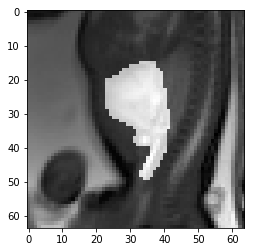

In [4]:
iImg = 900
plt.imshow(IMG_ARRAY[iImg] + SEG_ARRAY[iImg]*0.25, cmap='gray')

# Save Data

In [5]:
os.chdir(dataDir)
np.savez("fcmr_data.npz", \
         IMG_ARRAY=IMG_ARRAY, SEG_ARRAY=SEG_ARRAY, \
         fcmrNum_ARRAY=fcmrNum_ARRAY, \
         iStack_ARRAY=iStack_ARRAY, \
         iSlice_ARRAY=iSlice_ARRAY, \
         isSeg_ARRAY=isSeg_ARRAY)

print("Data saved ...")

Data saved ...


In [6]:
tom = np.load('fcmr_data.npz')
print(tom.files)

['IMG_ARRAY', 'SEG_ARRAY', 'fcmrNum_ARRAY', 'iStack_ARRAY', 'iSlice_ARRAY', 'isSeg_ARRAY']
